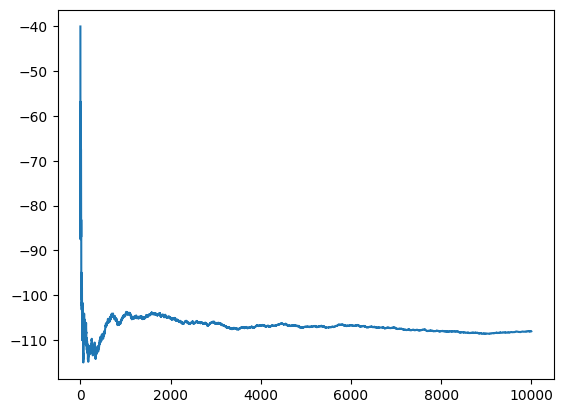

In [1]:
#Task 1.1
from time import sleep
from typing import Optional
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding
from commons import AbstractAgent, AbstractRLTask, get_crop_chars_from_observation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display
import torch

class GridWorld(gym.Env):
    metadata = {'render_modes': ['human', 'rgb_array']}
    reward_range = (-float("inf"), float("inf"))
    spec = None

    def __init__(self, n, m):
        super(GridWorld, self).__init__()
        self.n = n
        self.m = m
        self.action_space = spaces.Discrete(4)  # Up, Down, Right, Left
        self.observation_space = spaces.Tuple((spaces.Discrete(n), spaces.Discrete(m)))

        # Agent starts at (0, 0) and goal is at (n-1, m-1)
        self.position = (0, 0)
        self.goal = (n - 1, m - 1)

    #Run one timestep of the environment's dynamics. 
    #When end of episode is reached, you are responsible for calling `reset()` to reset this environment's state.
    def step(self, action):
        # Dictionary mapping actions to movements
        actions = {
            0: (-1, 0),  # Up
            1: (1, 0),   # Down
            2: (0, 1),   # Right
            3: (0, -1)   # Left
        }

        # Perform action
        movement = actions[action]
        new_position = (self.position[0] + movement[0], self.position[1] + movement[1])

        # Check if new position is within grid
        if 0 <= new_position[0] < self.n and 0 <= new_position[1] < self.m:
            self.position = new_position
           
        #observation (object): agent's observation of the current environment    
        observation = self.position
        
        #reward (float) : amount of reward returned after previous action
        reward = -1
        
        #done (bool): whether the episode has ended, in which case further step() calls will return undefined results
        done = self.position == self.goal
        
        #info (dict): contains auxiliary diagnostic information (helpful for debugging, logging, and sometimes learning)
        info = []

        return (observation, reward, done, info)

    #Resets the environment to an initial state and returns an initial observation.
    def reset(self,*, seed: Optional[int] = None, return_info: bool = False, 
              options: Optional[dict] = None):

        # Initialize the RNG if the seed is manually passed
        if seed is not None:
           self._np_random, seed = seeding.np_random(seed)

        self.position = (0,0)
        observation = self

        #info (optional dictionary): a dictionary containing extra information
        #this is only returned if return_info is set to true
        info = []

        if return_info:
            return observation, info
        return observation

    def render(self, mode="human"):
        """Renders the environment.

        The set of supported modes varies per environment. (And some
        third-party environments may not support rendering at all.)
        By convention, if mode is:

        - human: render to the current display or terminal and
          return nothing. Usually for human consumption.
        - rgb_array: Return an numpy.ndarray with shape (x, y, 3),
          representing RGB values for an x-by-y pixel image, suitable
          for turning into a video.
        - ansi: Return a string (str) or StringIO.StringIO containing a
          terminal-style text representation. The text can include newlines
          and ANSI escape sequences (e.g. for colors).
        """


        if mode == 'rgb_array':
            # Render the grid world as an RGB array
            rgb_array = np.zeros((self.n, self.m, 3), dtype=np.uint8)
            rgb_array[self.position] = [255, 0, 0]  # Red color for agent
            rgb_array[self.goal] = [0, 255, 0]   # Green color for goal

            return rgb_array
        
        # Initialize the ANSI character array
        ansi_grid = np.full((self.n, self.m), '.', dtype=str)  # Fill with '.'

        # Place the agent and goal
        ansi_grid[self.position] = '@'  # Agent
        ansi_grid[self.goal] = '>'  # Goal

        #ansi_grid = '\n'.join([''.join(row) for row in ansi_grid])
        
        if mode == 'ansi':
            return ansi_grid
        
        elif mode == 'human':
            print('\n'.join([' '.join(row) for row in ansi_grid]))
        
        else:
            super(GridWorld, self).render(mode=mode) # just raise an exception

class RLTask(AbstractRLTask):
    def __init__(self, env, agent):
        self.env = env
        self.agent = agent

    def interact(self, n_episodes):
        k = 0
        sum_returns = 0  # Store episode returns
        average_returns = []

        for k in range(n_episodes):
            episode_return = 0  # Initialize episode return
            state = self.env.reset()  # Reset the environment
            done = False
            SAR = []

            while not done:
                #print(get_crop_chars_from_observation(state))
                action = self.agent.act(state)  # Get action from the agent
                next_state, reward, done, _ = self.env.step(action)  # Take action in the environment
                SAR.append((state, action, reward))
                episode_return += reward  # Accumulate reward for the episode
                state = next_state  # Update observation for the next step
            
            sum_returns = sum_returns + episode_return
            Gk = 1 / (k + 1) * sum_returns

            average_returns.append(Gk)  # Store episode return
            k = k + 1

        #Gk = 1 / (k + 1) * sum(Gi)

        self.agent.onEpisodeEnd(self.agent, SAR)
        
        return average_returns

    def interactGPU(self, n_episodes):
        device = "cuda"
        k = 0
        sum_returns = 0  # Store episode returns
        average_returns = []

        for k in range(n_episodes):
            episode_return = 0  # Initialize episode return
            state = self.env.reset()  # Reset the environment
            done = False
            SAR = []

            while not done:
                # Move state to GPU if not already
                state_tensor = torch.tensor(state).to(device)
                
                # Get action from the agent
                action = self.agent.act(state_tensor)  # Get action from the agent
                
                # Take action in the environment
                next_state, reward, done, _ = self.env.step(action)
                
                # Move next_state to GPU if not already
                next_state_tensor = torch.tensor(next_state).to(device)
                
                # Store the SAR tuple
                SAR.append((state_tensor, action, reward))
                
                # Accumulate reward for the episode
                episode_return += reward  
                
                # Update observation for the next step
                state = next_state  
            
            # Accumulate returns
            sum_returns = sum_returns + episode_return
            
            # Calculate Gk
            Gk = 1 / (k + 1) * sum_returns
            
            # Store episode return
            average_returns.append(Gk)  
            
            k = k + 1

        # Call agent's onEpisodeEnd method
        self.agent.onEpisodeEnd(self.agent, SAR)

    def visualize_episode(self, max_number_steps = None):
        """
        This function executes and plot an episode (or a fixed number 'max_number_steps' steps).
        You may want to disable some agent behaviours when visualizing(e.g. self.agent.learning = False)
        :param max_number_steps: Optional, maximum number of steps to plot.
        :return:
        """
        obs = self.env.reset()  # Reset the environment
        done = False
        steps = 0
        
        plt.ioff()  # Turn off interactive mode to prevent additional plot

        frames = []
        while not done and (max_number_steps is None or steps < max_number_steps):
            uncroppedFrame = self.env.render('ansi')  # Render the environment
            
            if isinstance(uncroppedFrame, np.ndarray):
                frames.append(uncroppedFrame)
            
            else:
                croppedFrame = get_crop_chars_from_observation(obs)

                croppedFrame = [[chr(item) for item in row] for row in croppedFrame]
                
                frames.append(croppedFrame)



            action = self.agent.act(obs)  # Get action from the agent
            obs, _, done, _ = self.env.step(action)  # Take action in the environment
            steps += 1

        # Convert the ANSI arrays to lists of lists of strings
        ansi_arrays = [[[str(cell) for cell in row] for row in array] for array in frames]

        # Create a figure and axis
        fig, ax = plt.subplots()

        # Create a text object with the initial ANSI array
        text = ax.text(0.5, 0.5, '', ha='center', va='center', fontsize=18, fontfamily='monospace')

        # Hide the axis
        ax.axis('off')

        # Get the size of the ANSI array
        n_rows, n_cols = len(ansi_arrays[0]), len(ansi_arrays[0][0])

        # Set figure size to fit the text
        fig.set_size_inches(n_cols/3, n_rows/3)

        # Animation function
        def animate(i):
            # Update the text object with the next frame of the ANSI array
            text.set_text('\n'.join([' '.join(row) for row in ansi_arrays[i]]))

        # Create animation
        ani = FuncAnimation(fig, animate, frames=len(ansi_arrays), interval=100, repeat=True)

        # Display animation in Jupyter Notebook
        from IPython.display import HTML, display
        display(HTML(ani.to_jshtml()))

        # Reset agent learning status after visualization
        self.agent.learning = True

        #close plot to prevent overlaps
        plt.close()

class RandomAgent(AbstractAgent):
    def act(self, state, reward=-1):
        # Randomly select an action from the action space
        return self.action_space.sample()
    

Grid5x5 = GridWorld(5,5)

randAgent = RandomAgent(1,Grid5x5.action_space)

task = RLTask(Grid5x5,randAgent)

returns = task.interact(10000)
randInteract = plt.show(plt.plot(returns))

# Clear the current figure to prevent overlap
plt.close()

randVisualise = task.visualize_episode(100)

In [2]:
#Task 1.2
from commons import get_crop_chars_from_observation
from minihack_env import get_minihack_envirnment

class FixedAgent(AbstractAgent):
    def act(self, state, reward=0):
        #print(state)
        croppedstate = get_crop_chars_from_observation(state)
        #print(croppedstate)
        char_array = np.char.mod('%c', croppedstate)
        #print(char_array)
        if not (64 in croppedstate[-1]) and not ((croppedstate[-2] == 64).any() and croppedstate[-1][(croppedstate[-2] == 64).nonzero()[0][0]] == 45): #go down if you can
            return 2 #right

        else:  #otherwise go right
            return 1 #down

emptyRoom = get_minihack_envirnment("empty-room")
lavaRoom = get_minihack_envirnment("room-with-lava")

fixAgent = FixedAgent(1, emptyRoom.action_space)  

task = RLTask(emptyRoom,fixAgent)
emptyVisualise = task.visualize_episode(10) 

task = RLTask(lavaRoom,fixAgent)
lavaVisualise = task.visualize_episode(10) 


In [3]:
#Task 2.1
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
import random


def campaign(agent,environments, length):
    for env in environments:
        task = RLTask(env, agent)
        
        returns = task.interact(length)
        randInteract = plt.show(plt.plot(returns))

        # Clear the current figure to prevent overlap
        plt.close()

        randVisualise = task.visualize_episode(100)

        plt.close()

        #reset the agents q table
        agent.q_table = QTable(agent.action_space)

def campaign_parallel(agent, environments, length):
    with ThreadPoolExecutor(max_workers=10) as executor:
        # Submit interact() method for each environment to the thread pool
        futures = [executor.submit(RLTask(env, agent).interact, length) for env in environments]
        
        # Wait for all futures to complete and store only the average returns
        results = [future.result() for future in futures]
        
        # Visualize episodes and reset the agent's Q-table
        for avg_return, env in zip(results, environments):
            randInteract = plt.show(plt.plot(avg_return))
            task = RLTask(env, agent)
            
            # Visualize episode
            task.visualize_episode(100)
            
            # Reset the agent's Q-table
            agent.q_table = QTable(agent.action_space)

class RLTask(AbstractRLTask):
    def __init__(self, env, agent):
        self.env = env
        self.agent = agent
        self.lastState = None
        self.lastObservation = None
    
    def observe(self, state):
        #if state is the same as the last state use previous observation
        #print('state',state['chars'])
        #print('laststate',self.lastState)

        if tuple(state['chars'].flatten()) == tuple(self.lastState.flatten()):
            return self.lastObservation
        #if np.array_equal(state['chars'], self.lastState):
            return self.lastObservation
        else:
            self.lastState = state['chars']

        observation = get_crop_chars_from_observation(state)

        # Pad the space with blanks
        observation = np.pad(observation, 1, constant_values=32)

        if 64 not in observation or 62 not in observation:
        # If either 64 or 62 is not present, return a default observation
            location = [0,0]
            goal = [0,0]
        else:
            location = np.argwhere(observation == 64)[0]
            goal = np.argwhere(observation == 62)[0]

        delta_x = goal[1] - location[1]
        delta_y = goal[0] - location[0]

        # Calculate the direction to the goal
        direction_mapping = {
            (-1, -1): 1,  # North-West
            (-1, 0): 2,   # North
            (-1, 1): 3,   # North-East
            (0, -1): 4,   # West
            (0, 0): 5,    # No movement (same position)
            (0, 1): 6,    # East
            (1, -1): 7,   # South-West
            (1, 0): 8,    # South
            (1, 1): 9,    # South-East
        }

        goal_direction = direction_mapping[(np.sign(delta_x), np.sign(delta_y))]

        #grid 3x3 grid centered on character
        # Generate the grid around point 64
        row_start = max(0, location[0] - 1)
        row_end = min(observation.shape[0], location[0] + 2)
        col_start = max(0, location[1] - 1)
        col_end = min(observation.shape[1], location[1] + 2)
        
        grid_around_character = observation[row_start:row_end, col_start:col_end]
        # Flatten the grid and convert to a tuple
        flattened_grid = grid_around_character.flatten()
        
        # Generate the identifier tuple
        observation = tuple(np.append(flattened_grid, goal_direction))
        self.lastObservation = observation

        print('new',observation)
        #print(observation)
        return observation
    
    # def observe(self, state):
    #     observation = get_crop_chars_from_observation(state)     
    #     observation = tuple(observation.flatten())
    #     return observation
    
    def interact(self, n_episodes):
        k = 0
        sum_returns = 0  # Store episode returns
        average_returns = []
        self.agent.learning = True

        for k in range(n_episodes-1):
            episode_return = 0  # Initialize episode return
            state = self.observe(self.env.reset())# Reset the environment
            done = False
            SAR = []

            while not done:
                action = self.agent.act(state)  # Get action from the agent
                next_state, reward, done, _ = self.env.step(action)  # Take action in the environment

                if done:
                    break

                next_state = self.observe(next_state)
                SAR.append((state, action, reward))
                episode_return += reward  # Accumulate reward for the episode
                state = next_state  # Update observation for the next step
            
            sum_returns = sum_returns + episode_return
            Gk = 1 / (k + 1) * sum_returns

            average_returns.append(Gk)  # Store episode return
            k = k + 1

            #Gk = 1 / (k + 1) * sum(Gi)
            if self.agent.learning:
                self.agent.onEpisodeEnd(self.agent, SAR)
        return average_returns
    
    def visualize_episode(self, max_number_steps = None):
        """
        This function executes and plot an episode (or a fixed number 'max_number_steps' steps).
        You may want to disable some agent behaviours when visualizing(e.g. self.agent.learning = False)
        :param max_number_steps: Optional, maximum number of steps to plot.
        :return:
        """
        self.agent.learning = False
        state = self.env.reset()  # Reset the environment
        done = False
        steps = 0
        
        plt.ioff()  # Turn off interactive mode to prevent additional plot

        frames = []
        while not done and (max_number_steps is None or steps < max_number_steps):
            uncroppedFrame = self.env.render('ansi')  # Render the environment
            
            if isinstance(uncroppedFrame, np.ndarray):
                frames.append(uncroppedFrame)
            
            else:
                croppedFrame = get_crop_chars_from_observation(state)

                croppedFrame = [[chr(item) for item in row] for row in croppedFrame]
                
                frames.append(croppedFrame)


            observation = self.observe(state)
            action = self.agent.act(observation)  # Get action from the agent
            state, _, done, _ = self.env.step(action)  # Take action in the environment
            steps += 1

        # Convert the ANSI arrays to lists of lists of strings
        ansi_arrays = [[[str(cell) for cell in row] for row in array] for array in frames]

        # Create a figure and axis
        fig, ax = plt.subplots()

        # Create a text object with the initial ANSI array
        text = ax.text(0.5, 0.5, '', ha='center', va='center', fontsize=18, fontfamily='monospace')

        # Hide the axis
        ax.axis('off')

        # Get the size of the ANSI array
        n_rows, n_cols = len(ansi_arrays[0]), len(ansi_arrays[0][0])

        # Set figure size to fit the text
        fig.set_size_inches(n_cols/3, n_rows/3)

        # Animation function
        def animate(i):
            # Update the text object with the next frame of the ANSI array
            text.set_text('\n'.join([' '.join(row) for row in ansi_arrays[i]]))

        # Create animation
        ani = FuncAnimation(fig, animate, frames=len(ansi_arrays), interval=100, repeat=True)

        # Display animation in Jupyter Notebook
        from IPython.display import HTML, display
        display(HTML(ani.to_jshtml()))

        # Reset agent learning status after visualization
        self.agent.learning = True

        #close plot to prevent overlaps
        plt.close()

class QTable:
    def __init__(self, action_space):
        # Initialize Q-table with default values for all state-action pairs
        self.q_values = defaultdict(lambda: [0] * action_space.n)
        self.action_space = action_space

    def update_q_value(self, state, action, q_value):
        # Update Q-value for a state-action pair
        if state not in self.q_values:
            self.q_values[state] = [0] * self.action_space.n  # Initialize Q-values for the state if not already present
        self.q_values[state][action] = q_value

    def get_q_value(self, state, action):
        # Get Q-value for a state-action pair
        return self.q_values[state][action]

environments = []
environments.append(get_minihack_envirnment("empty-room"))
#environments.append(get_minihack_envirnment("room-with-lava"))
#environments.append(get_minihack_envirnment("room-with-monster"))
#environments.append(get_minihack_envirnment("cliff-minihack"))

#Monte Carlo On-policy
class monteCarlo():   
    def __init__(self, action_space, epsilon):
        self.action_space = action_space
        self.q_table = QTable(action_space)
        self.epsilon = epsilon  
        self.learning = True

    def act(self, state):
        state_key = state
        q_values = self.q_table.q_values[state_key]
        #print(q_values)
        # Ensure that q_values has a default value for each action

        if (random.random() < self.epsilon) and self.learning:
            # Choose a random action
            return self.action_space.sample()
        else:
            # Choose the action with the highest Q-value
            max_q_value = np.max(q_values)
            max_q_indices = np.where(q_values == max_q_value)[0]
            return np.random.choice(max_q_indices)

    def onEpisodeEnd(_, agent, SAR):
        G = 0
        agent.epsilon = agent.epsilon/1.01
        for t in reversed(range(len(SAR))):
            state, action, reward = SAR[t]
            G = reward + G
            state_key = state  # Use the observe function to preprocess the state
            if (state_key, action) not in [(x[0], x[1]) for x in SAR[0:t]]:
                # Update Q-value using the mean of returns for the state-action pair
                agent.q_table.update_q_value(state_key, action, G)

mCarlo = monteCarlo(environments[0].action_space,0.1)

campaign(mCarlo, environments, 1000)

#campaign(mCarlo, environments, 1000)

# #Temporal Difference On-policy (SARSA)
# class TD_onPolicy():
#     def __init__(self, id, action_space):
#         self.id = id
#         self.action_space = action_space

# TDon = TD_onPolicy(1, emptyRoom.action_space)
# campaign(TDon, environments)

# #Temporal Difference Off-policy (Q-learning)
# class TD_offPolicy():
#     def __init__(self, id, action_space):
#         self.id = id
#         self.action_space = action_space

# TDoff = TD_offPolicy(1, emptyRoom.action_space)
# campaign(TDoff, environments)

AttributeError: 'NoneType' object has no attribute 'flatten'

In [ ]:
#Task 2.2

In [ ]:
#Task 2.3
class dynaQ():
    def __init__(self, id, action_space):
        self.id = id
        self.action_space = action_space

dynaQ = dynaQ(1,)

TypeError: __init__() missing 1 required positional argument: 'action_space'

In [ ]:
import gym
import random


import minihack
import numpy as np

#Monte Carlo On-policy
class monteCarlo():   
    def __init__(self, action_space, epsilon):
        self.action_space = action_space
        self.q_values = {}
        self.returns = {}  
        self.epsilon = epsilon  

        # Flag that you can change for distinguishing whether the agent is used for learning or for testing.
        # You may want to disable some behaviour when not learning (e.g. no update rule, no exploration eps = 0, etc.)
        self.learning = True


    def act(self, srandomreward = 0):
        state_key = tuple(state)  # Convert NumPy array to tuple
        if state_key not in self.q_values:
            self.q_values[state_key] = [0] * self.action_space.n

        # epsilon-greedy
        if random.random() < self.epsilon:
            # Choose a random action
            return random.randint(0, self.action_space.n - 1)
        else:
            # Choose the action with the highest Q-value
            max_q_value = max(self.q_values[state_key])
            max_q_indices = [i for i, q in enumerate(self.q_values[state_key]) if q == max_q_value]
            random.shuffle(max_q_indices)  # Shuffle indices to break ties randomly
            return max_q_indices[0]
    
    #def onEpisodeEnd(self, reward, episode):
    def onEpisodeEnd(_, agent, SAR):
        """
        This function can be exploited to allow the agent to perform some internal process (e.g. learning-related) at the
        end of an episode.
        :param reward: the reward obtained in the last step
        :param episode: the episode number
        :return:
        """
        G = 0
        for t in reversed(range(len(SAR))):
            state, action, reward = SAR[t]
            G = reward + G
            state_action = (tuple(state), action)  # Convert state to tuple
            if state_action not in [(x[0], x[1]) for x in SAR[0:t]]:
                if state_action in agent.returns:
                    agent.returns[state_action].append(G)
                    agent.q_values[state_action[0]][state_action[1]] = np.mean(agent.returns[state_action])

# Define environment
env = get_minihack_envirnment("empty-room")
mCarlo = monteCarlo(emptyRoom.action_space,0.1)
task = RLTask(env, agent)
returns = task.interact(1000)
randInteract = plt.show(plt.plot(returns))

# Clear the current figure to prevent overlap
plt.close()

randVisualise = task.visualize_episode(100)

plt.close()

NameError: name 'agent' is not defined